<a href="https://colab.research.google.com/github/yukinaga/bert_nlp/blob/main/section_2/01_pytorch_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorchの基礎
PyTorchの基礎を学ぶために、ニューラルネットワークを訓練して手書き文字の認識を行います。 


## データの読み込み
`torchvision.datasets`を使って手書き文字のデータを読み込み、**DataLoader**を設定します。  
DataLoaderを使うと、データの読み込みやミニバッチ法の実装などが大幅に楽になります。   
`torchvision.datasets`にはMNISTの他にも様々なデータセットが用意されています。  
https://pytorch.org/docs/stable/torchvision/datasets.html


In [78]:
import torch
from torchvision.datasets import MNIST  # 手書き文字画像のデータ
from torchvision import transforms
from torch.utils.data import DataLoader

# 訓練データを取得
mnist_train = MNIST("./data", 
                    train=True, download=True,#train data
                    transform=transforms.ToTensor())
# テストデータの取得
mnist_test = MNIST("./data",#保存場所
                   train=False, download=True,#test data
                   transform=transforms.ToTensor())
print("訓練データの数:", len(mnist_train), "テストデータの数:", len(mnist_test))

# DataLoaderの設定
img_size = 28
batch_size = 256
train_loader = DataLoader(mnist_train, #train用dataset指定
                          batch_size=batch_size,#バッチサイズ指定
                          shuffle=True)#randomに取り出す
test_loader = DataLoader(mnist_test,#test用dataset指定
                         batch_size=batch_size,
                         shuffle=False)

訓練データの数: 60000 テストデータの数: 10000


手書き文字の画像サイズは、28×28になります。  



## モデルの構築
今回は、`nn.Module`モジュールを継承したクラスとして、モデルを構築します。  
`.cuda()`により、モデルの計算はGPU上で行われるようになります。  

In [79]:
import torch.nn as nn
import torch.nn.functional as F#活性化関数など

class Net(nn.Module):#Netクラスを定義-nn.Moduleを継承
    def __init__(self):#Initializer=コンストラクタ
        super().__init__()
        self.fc1 = nn.Linear(img_size*img_size, 1024)  # free conected,nn.Linear=全結合層＝前後の層が全て結合 入力数：全ピクセル数なのでimg_size*img_size　中間層のニューロン：1024
        self.fc2 = nn.Linear(1024, 512)#入力1024 出力512
        self.fc3 = nn.Linear(512, 10)#入力512 出力10

    def forward(self, x):#順伝搬のメソッド
        x = x.view(-1, img_size*img_size)  # テンソルサイズ変換　バッチサイズ:-1(自動的に調整) 入力の数:img_size*img_size
        x = F.relu(self.fc1(x))#xをfc1に入れてrelu
        x = F.relu(self.fc2(x))#xをfc2に入れてrelu
        x = self.fc3(x)#全結合層に入れて
        return x#返り値

net = Net()
# net.cuda()  # GPU対応
print(net)#モデルを表示

Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


In [81]:
net.parameters

<bound method Module.parameters of Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)>

### データセットを取り出し

train1_x.shape torch.Size([1, 28, 28])
train1_y tensor([6])
train1_y torch.Size([1])


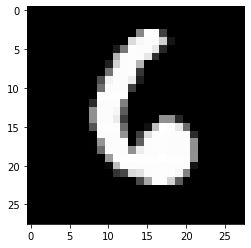

In [82]:
import matplotlib.pyplot as plt
train1=[x for x in train_loader][0]
train1_x=train1[0][0]
train1_y=train1[1][0].reshape(1)

# print((train1_x))
print('train1_x.shape',train1_x.shape)
plt.imshow(train1_x.reshape((28, 28)), cmap='gray')
print('train1_y',train1_y)
print('train1_y',train1_y.shape)

### 作ったモデルでテスト

In [86]:
pred1_y=net(train1_x)
print('pred1_y:',pred1_y)
print('pred1_y.argmax(1):',pred1_y.argmax(1))
loss=loss_fnc(pred1_y, train1_y)
print('loss:',loss.item())

pred1_y: tensor([[ 0.0330,  0.0012, -0.0364, -0.0611,  0.0098,  0.0058,  0.0391, -0.0485,
         -0.0064, -0.0259]], grad_fn=<AddmmBackward>)
pred1_y.argmax(1): tensor([6])
loss: 2.255065441131592


## 学習
モデルを訓練します。  
DataLoaderを使い、ミニバッチを取り出して訓練および評価を行います。  

1エポックの中で何度もミニバッチを使って訓練が行われるので、ミニバッチ法が実装されていることになります。  
学習には時間がかかりますので、編集→ノートブックの設定のハードウェアアクセラレーターにGPUが選択されていることを確認しましょう。


In [34]:
from torch import optim#最適化アルゴリズム

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()#誤算関数を指定

# SGD
optimizer = optim.SGD(net.parameters(), lr=0.01)#optimizerを設定　　lr学習係数

# 損失のログ
record_loss_train = []#訓練誤差記録用リスト
record_loss_test = []#テスト誤差記録用リスト

# 学習
for i in range(10):  # 10エポック学習
    net.train()  # 訓練モードにする
    loss_train = 0 #誤差初期値0に設定
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
        # x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)#先のモデルにx入力
        loss = loss_fnc(y, t)#誤差を計算
        loss_train += loss.item()#計算誤差を足していく、.itemはテンソルから値を取り出すメソッド
        optimizer.zero_grad()#勾配の値をリセット
        loss.backward()#誤差逆伝搬を行う,勾配の計算のみ。
        optimizer.step()#パラメータ更新を行う
    loss_train /= j+1#1エポック数の平均で割る
    record_loss_train.append(loss_train)#record_loss_trainにappend

    net.eval()  # 評価モード
    loss_test = 0#誤差初期値
    for j, (x, t) in enumerate(test_loader):  # ミニバッチ（x, t）を取り出す
        # x, t = x.cuda(), t.cuda()
        y = net(x)#順伝搬
        loss = loss_fnc(y, t)#誤差計算
        loss_test += loss.item()#誤差を足していく
    loss_test /= j+1
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 2.2188826043555077 Loss_Test: 2.091896706819534
Epoch: 1 Loss_Train: 1.8313291909846854 Loss_Test: 1.4542297929525376
Epoch: 2 Loss_Train: 1.1288062108323929 Loss_Test: 0.8396207392215729
Epoch: 3 Loss_Train: 0.7290333950773199 Loss_Test: 0.6035501591861248
Epoch: 4 Loss_Train: 0.5678150284797587 Loss_Test: 0.4972286742180586
Epoch: 5 Loss_Train: 0.4869718133135045 Loss_Test: 0.43742791600525377
Epoch: 6 Loss_Train: 0.43876032119101666 Loss_Test: 0.39988933857530357
Epoch: 7 Loss_Train: 0.40705351487119146 Loss_Test: 0.37502485159784554
Epoch: 8 Loss_Train: 0.3835600241701654 Loss_Test: 0.3559173052199185
Epoch: 9 Loss_Train: 0.366364316356943 Loss_Test: 0.3408895983360708


## 誤差の推移
訓練データ、テストデータで誤差の推移をグラフ表示します。  

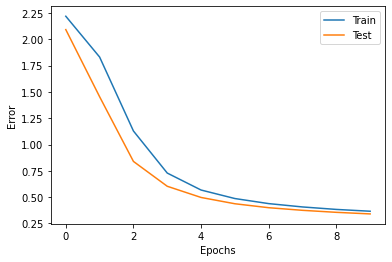

In [35]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## 正解率
モデルの性能を把握するため、テストデータ使い正解率を測定します。  

In [36]:
correct = 0#正解数
total = 0#
for i, (x, t) in enumerate(test_loader):
    # x, t = x.cuda(), t.cuda()  # GPU対応
    x = x.view(-1, img_size*img_size)
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()#
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 90.24%
